In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse 
from google.colab import drive
import pprint
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! unzip "/content/gdrive/MyDrive/project/data_upload_v3.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data_upload_v3/test/non/Atelectasis/patient04316-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04347-study7-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04382-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04437-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04466-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04689-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04733-study7-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04773-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04773-study4-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient04826-study1-view1_frontal.jpg  
  inflating: data_upload_v3/test/non/Atelectasis/patient049

In [ ]:
data_dir='data_upload_v3/'
test_size_covid = 100
test_size_non_covid = 3000
test_size = test_size_covid + test_size_non_covid

#**Data Augmentation**

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        im = Image.open(os.path.join(folder,filename))
        if im:
            images.append(im)
    return images

In [ ]:
train_covid = load_images_from_folder(f"{data_dir}/train/covid")

In [ ]:
len(train_covid)

84

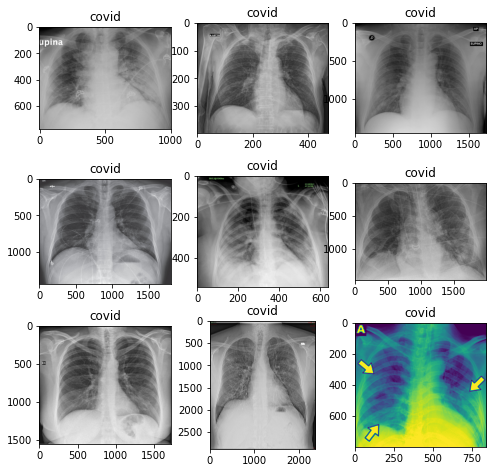

In [ ]:
plt.figure(figsize=(8,8))
n = 3
for i in range(n*n):
    ax=plt.subplot(n,n,i+1)
    ax.title.set_text('covid')
    plt.imshow(train_covid[i])
plt.show() 

##**rescale to 224*224**

In [ ]:
resizer_transforms = transforms.Compose([
        transforms.Resize((224,224)),
])
based_covid_images = [resizer_transforms(img) for img in train_covid]

In [ ]:
len(based_covid_images)

84

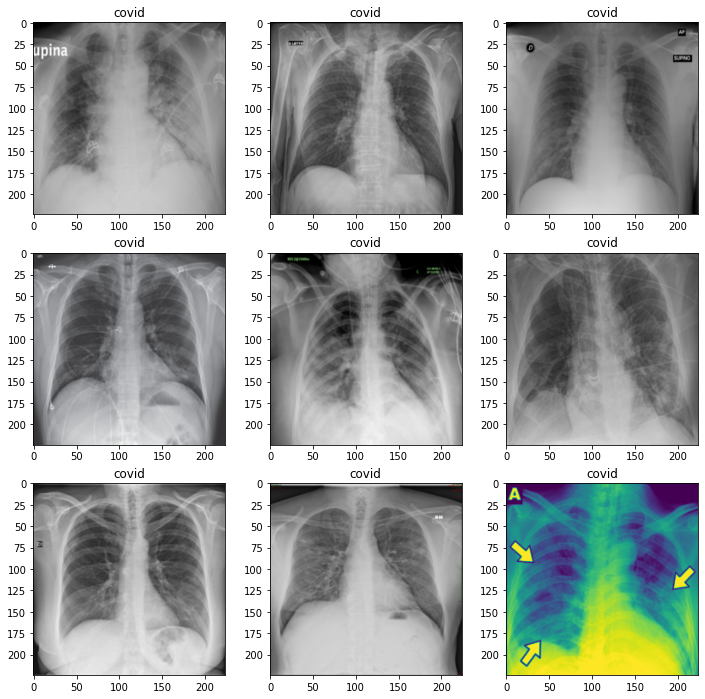

In [ ]:
plt.figure(figsize=(12,12))
for i in range(n*n):
    ax=plt.subplot(n,n,i+1)
    ax.title.set_text('covid')
    plt.imshow(based_covid_images[i])
plt.show() 

In [ ]:
augment_options = [transforms.Compose([
                        transforms.RandomRotation(10)
                ]), 
                transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip()
                ]),
                transforms.Compose([
                        transforms.GaussianBlur(kernel_size=3, sigma=2.0)
                ]),
                transforms.Compose([
                    transforms.ColorJitter(brightness=(0.5,1.5),contrast=(0.05),saturation=(0.5,1.5),hue=(-0.1,0.1)), 
                    # transforms.RandomEqualize()
                ])
                  ] 

##**apply all transformation on based image**

transformed : 84 , total : 84
------------------------------------------------------------


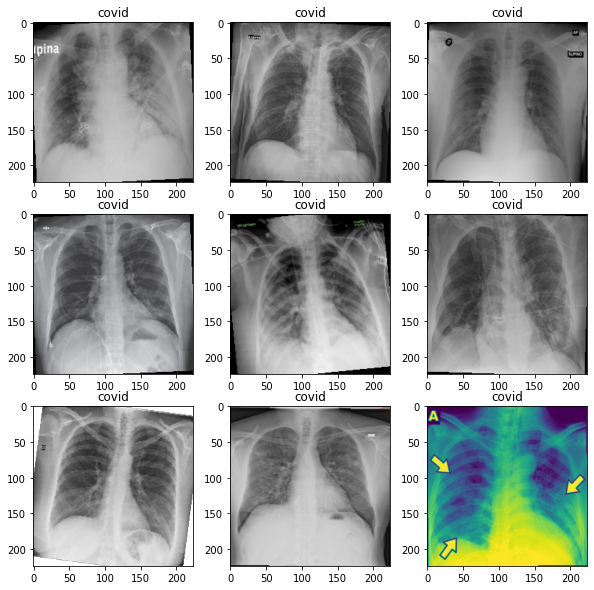

transformed : 84 , total : 168
------------------------------------------------------------


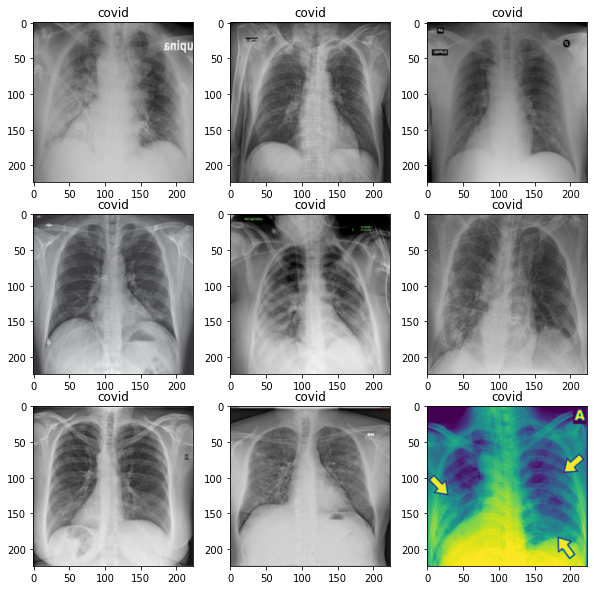

transformed : 84 , total : 252
------------------------------------------------------------


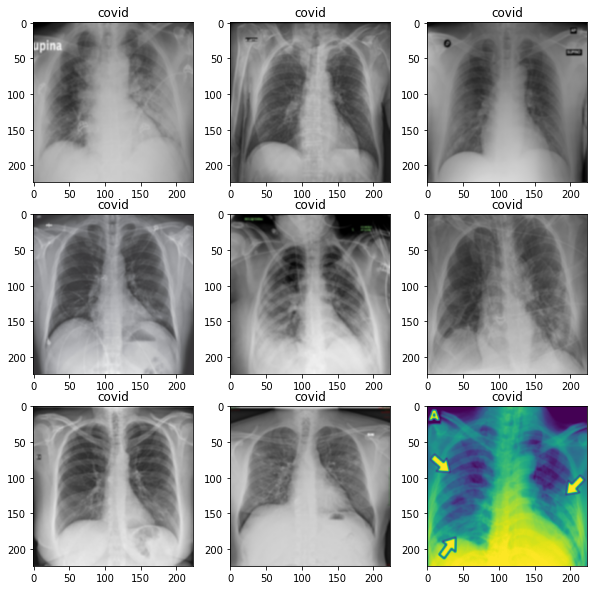

transformed : 84 , total : 336
------------------------------------------------------------


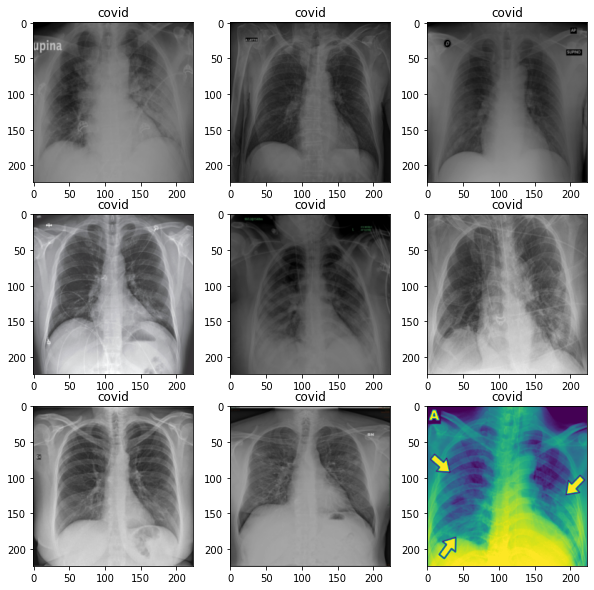

In [ ]:
augmented_covid_images = []
for aug_opt in augment_options:
    transformed_images = [aug_opt(img) for img in based_covid_images]
    augmented_covid_images += transformed_images
    print(f"transformed : {len(transformed_images)} , total : {len(augmented_covid_images)}")
    plt.figure(figsize=(10,10))
    for i in range(n*n):
        ax=plt.subplot(n,n,i+1)
        ax.title.set_text('covid')
        plt.imshow(transformed_images[i])
    print("-" * 60)
    plt.show()

In [ ]:
len(augmented_covid_images)

336

##**save images into covid folder**

In [ ]:
curr_image_num = 0
for item in augmented_covid_images:
  item.save(f'{data_dir}/train/covid/{curr_image_num}.png')
  print(curr_image_num)
  curr_image_num += 1

#**PreProcessing Data**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 20,
                                             shuffle=True, num_workers= 0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_time= time.time()
epochs = 30
batch_size = 20 

#**Train Model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:
sm = torch.nn.Softmax()

In [ ]:
i = 0
map_dict = {0 : 0, 1 : 0}
for input, label in image_datasets["test"]:

  map_dict[label] +=1
  # print(label)
  # print(input)
  # print(input.shape)
  i += 1
map_dict

{0: 100, 1: 3000}

#**Utils for evaluating model**

In [ ]:
def evaluate_model_with_new_metrics(test_images , threshold):
  num_covid_predicted = 0 # our model predicted covid 
  num_non_covid_predicted = 0 # our model predicted non covid
  predicted_labels = []
  true_labels = []
  covid_probabilities = []
  non_covid_prababolities = []
  a_covid_p_non = 0  # actual covid but predicted non covid
  a_non_p_covid = 0  # actual non covid but predicted covid 
  # label = 0 it's covid and label = 1 it's non covid

  for img, label in test_images:
    true_labels.append(label)

    probability_out = sm(model(img.reshape(1, 3, 224, 224)))
    if float(probability_out[0][0]) > threshold: # covid detected
      num_covid_predicted += 1
      predicted_labels.append(0)

    else: # non covid detected
      num_non_covid_predicted += 1
      predicted_labels.append(1)

    if label == 0: # add probabilites for covid prediction
        covid_probabilities.append(probability_out.data.numpy()[0,0])
    if label == 1: # add probabilites for non covid prediction
        non_covid_prababolities.append(probability_out.data.numpy()[0,0])
    
    true = label
    predicted = predicted_labels[-1]
    if true == 0 and predicted == 1: # defining FN
      a_covid_p_non += 1
    elif true == 1 and predicted == 0: # defining FP
      a_non_p_covid += 1

  print(f'FN : {a_covid_p_non}')
  print(f'FP : {a_non_p_covid}')
  print(f'predicted covid : {num_covid_predicted}' )
  print(f'predicted non covid : {num_non_covid_predicted}' )
  sensivity = (test_size_covid - a_covid_p_non) / test_size_covid
  specificity =  (test_size_non_covid - a_non_p_covid) / test_size_non_covid
  print(f'sensitivity : {sensivity}')
  print(f'specificity is : {specificity}')
  ConfusionMatrix(predicted_labels , true_labels)
  plt.figure()
  Roc(covid_probabilities, non_covid_prababolities , num_covid_predicted , num_non_covid_predicted, threshold)
  return covid_probabilities, non_covid_prababolities
  


In [ ]:
def Roc(covid_probabilities, non_covid_probabilities, num_covid_predicted, num_non_covid_predicted, threshold):
  y_test_res18= [1 for i in range(len(covid_probabilities))]+[0 for i in range(len(non_covid_probabilities ))]
  y_pred_res18= [1 for i in range(num_covid_predicted)]+[0 for i in range(num_non_covid_predicted)]

           
  auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
  ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

  plt.figure()
  pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='   AUC= %.3f'   %auc_res18) 
  pyplot.ylim([0,1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title("ROC Curve threshold is %.2f "  %threshold)
  pyplot.legend(loc='lower right')
  plt.show()


In [ ]:
def hist_probability_plot(covid_probabilites, non_covid_probabilites ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_probabilites, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_covid_probabilites, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')

In [ ]:
def ConfusionMatrix(predicted_labels , true_labels):
  y_pred= np.asarray(predicted_labels, dtype=np.int64)
  y_test= np.asarray(true_labels, dtype=np.int64)
  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   
  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])
  ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['COVID','Non-COVID'], yticklabels= ['COVID','Non-COVID'])
  ax.set_title("Confusion matrix")



# **Squeeznet**

##**Change Classifier Layer And Train**

In [ ]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
      
model_conv.classifier =nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 2, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_squeznet.pt')






/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule

Streaming output truncated to the last 5000 lines.
preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
28-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
       device='cuda:0')
28-th epoch, 119-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
28-th epoch, 120-th batch (size=20), train acc= 0.950 


preds: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  

##**Save Model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model =  './covid_squeznet.pt'
model= torch.load(trained_model, map_location='cpu') 


## **Model Evaluation**

for threshold : 0.1


<ipython-input-79-f79dc43f5a96>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability_out = sm(out)


FN : 10
TN : 26
predicted covid : 116
predicted non covid : 2984
sensitivity : 0.9
specificity is : 0.9913333333333333


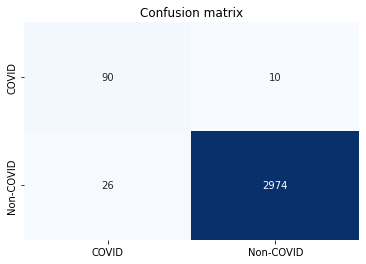

<Figure size 432x288 with 0 Axes>

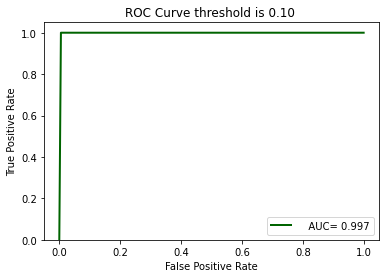

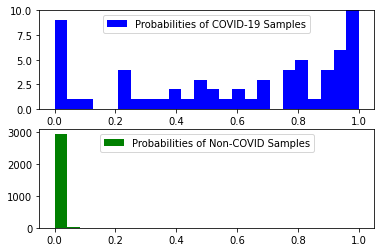

<Figure size 432x288 with 0 Axes>

for threshold : 0.15


<ipython-input-79-f79dc43f5a96>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability_out = sm(out)


FN : 11
TN : 17
predicted covid : 106
predicted non covid : 2994
sensitivity : 0.89
specificity is : 0.9943333333333333


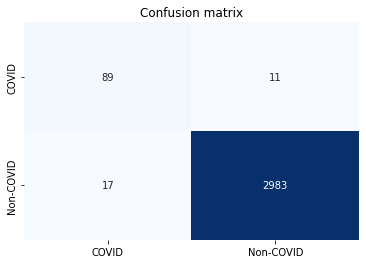

<Figure size 432x288 with 0 Axes>

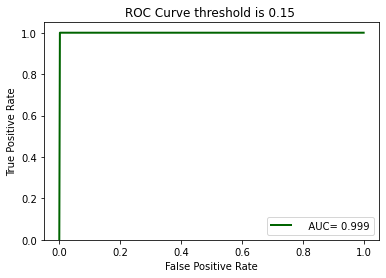

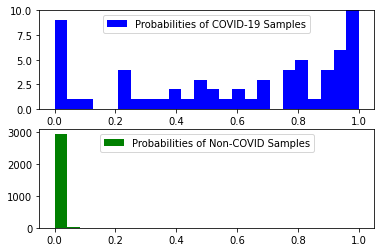

<Figure size 432x288 with 0 Axes>

for threshold : 0.2


<ipython-input-79-f79dc43f5a96>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability_out = sm(out)


FN : 11
TN : 14
predicted covid : 103
predicted non covid : 2997
sensitivity : 0.89
specificity is : 0.9953333333333333


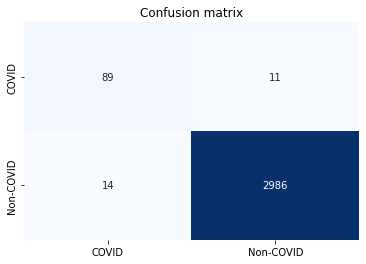

<Figure size 432x288 with 0 Axes>

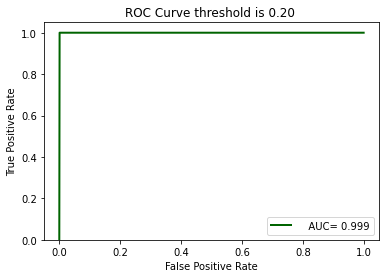

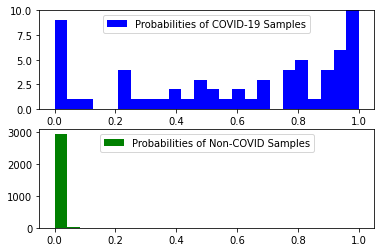

<Figure size 432x288 with 0 Axes>

for threshold : 0.4


<ipython-input-79-f79dc43f5a96>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability_out = sm(out)


FN : 20
TN : 7
predicted covid : 87
predicted non covid : 3013
sensitivity : 0.8
specificity is : 0.9976666666666667


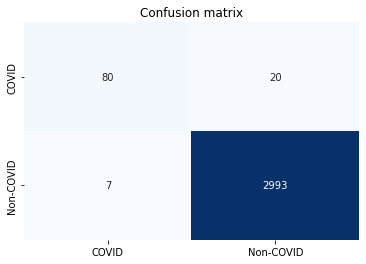

<Figure size 432x288 with 0 Axes>

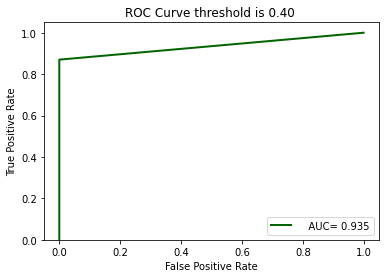

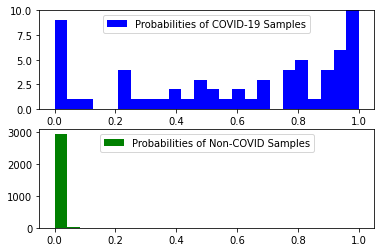

<Figure size 432x288 with 0 Axes>

for threshold : 0.5


<ipython-input-79-f79dc43f5a96>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability_out = sm(out)


FN : 24
TN : 4
predicted covid : 80
predicted non covid : 3020
sensitivity : 0.76
specificity is : 0.9986666666666667


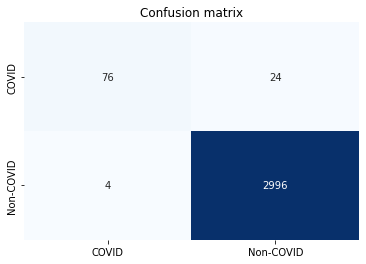

<Figure size 432x288 with 0 Axes>

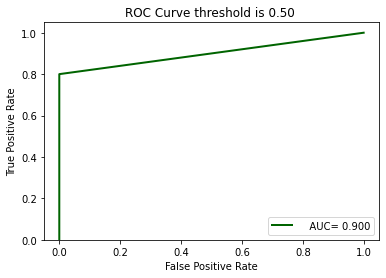

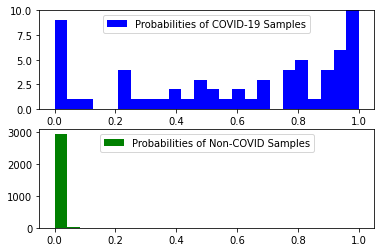

<Figure size 432x288 with 0 Axes>

In [ ]:
thresholds = [0.1, 0.15, 0.2, 0.4, 0.5]

for thresh in thresholds:
  print(f"for threshold : {thresh}")
  covid_prob , non_prob = evaluate_model_with_new_metrics(image_datasets['test'] , thresh)
  hist_probability_plot(covid_prob , non_prob)
  plt.figure()
  plt.show()